In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# fname = "2019-11-11-timings-scipy-pr11031bug.parquet"  # bug in timings
# fname = "2019-11-12-timings-scipy-1.2.0.parquet"
fname = "2019-11-13-timings-pr11031.parquet"

fig_id = fname.replace(".parquet", "").split("-")[-1:]
fig_id = "-".join(fig_id)
print(fig_id)
df = pd.read_parquet(fname)  # long overnight with PR
print(len(df))

pr11031
24660


In [3]:
df.pivot_table(
    columns="ndim", 
    index="mode",
    values="fft_time",
    aggfunc=len
)

ndim,1,2
mode,,
full,4110.0,4110.0
same,4110.0,4110.0
valid,4110.0,4110.0


In [4]:
df["ratio"] = df["auto_time"] / np.minimum(df["fft_time"], df["direct_time"])
df["ratio"] = df["auto_time"] / np.minimum(df["fft_time"], df["direct_time"])

In [5]:
df["correct"] = False
idx = (df["choose_conv_method"] == "direct") & (df["direct_time"] < df["fft_time"])
df.loc[idx, "correct"] = True
idx = (df["choose_conv_method"] == "fft") & (df["fft_time"] < df["direct_time"])
df.loc[idx, "correct"] = True

In [6]:
df["correct"].mean()

0.9223033252230333

In [7]:
df.head()

,x_shape,h_shape,seed,mode,ndim,choose_conv_method,fft_time,direct_time,auto_time,x_shape0,h_shape0,x_shape1,h_shape1,ratio,correct
0,13.0,8736.0,0,full,1,direct,0.000650,0.000259,0.000273,NaN,NaN,NaN,NaN,1.054278,True
1,NaN,NaN,0,full,2,fft,0.000456,0.085192,0.000391,18.0,42.0,45.0,87.0,0.857666,True
2,13.0,8736.0,0,valid,1,direct,0.000376,0.000171,0.000189,NaN,NaN,NaN,NaN,1.104749,True
3,NaN,NaN,0,valid,2,fft,0.000387,0.016468,0.000318,45.0,18.0,87.0,42.0,0.820308,True
4,13.0,8736.0,0,same,1,fft,0.000412,0.001042,0.000355,NaN,NaN,NaN,NaN,0.861530,True


In [8]:
df.groupby(["ndim", "mode"])["correct"].mean()

ndim  mode 
1     full     0.847445
      same     0.853528
      valid    0.854988
2     full     0.999027
      same     0.995864
      valid    0.982968
Name: correct, dtype: float64

In [9]:
df.groupby(["ndim", "mode"])["ratio"].max()

ndim  mode 
1     full     5.769458
      same     4.761905
      valid    4.952924
2     full     1.775490
      same     2.316306
      valid    2.007960
Name: ratio, dtype: float64

In [10]:
def log_round(x, base=2, decimals=0):
    power = np.log(x) / np.log(base)
    return base ** power.round(decimals=decimals)

kwargs = {"base": 1.2} if len(df) > 10_000 else {"base": 1.3}
df["direct_time_binned"] = log_round(df.direct_time, **kwargs)
print(kwargs)

{'base': 1.2}


In [11]:
df["np_conv"] = ""
idx = (df["mode"] == "same") & (df["ndim"] == 1)
np_conv = idx & (df["h_shape"] <= df["x_shape"])
df.loc[(np_conv & idx), "np_conv"] = "np_conv"
df.loc[((~np_conv) & idx), "np_conv"] = "sp_conv"
# df.np_conv

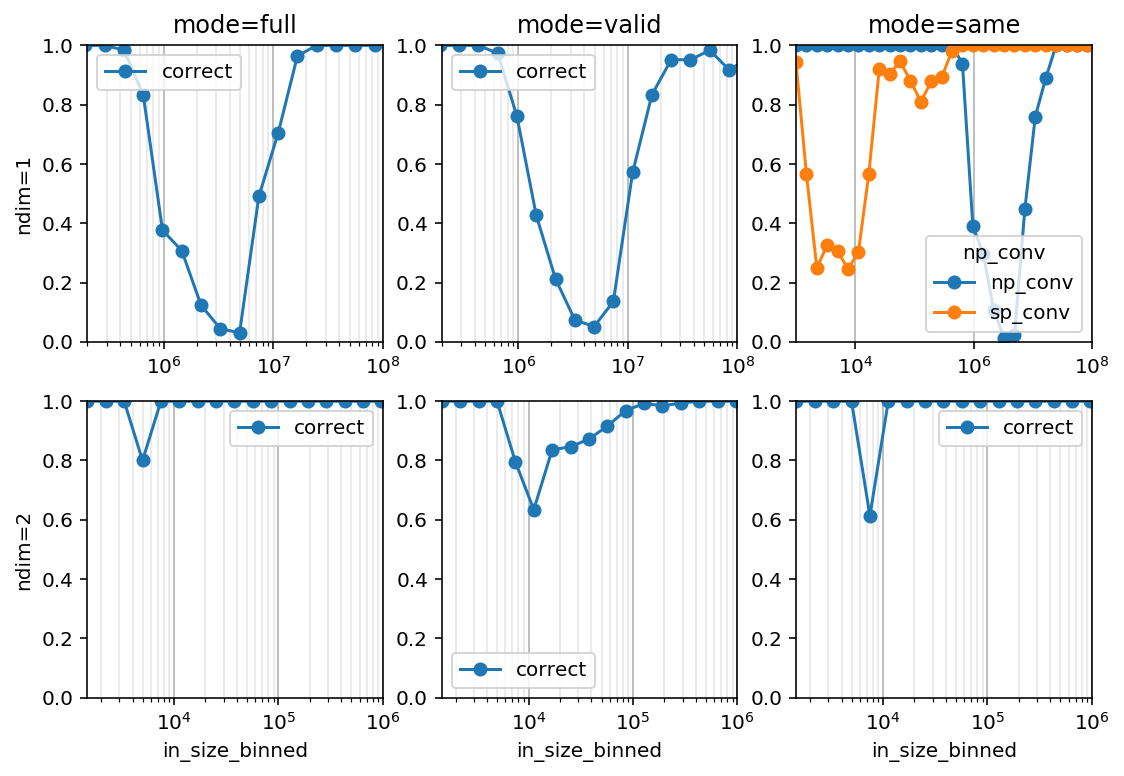

In [12]:
idx = df.x_shape.isnull().values
for pre in ["x", "h"]:
    df[f"{pre}_size"] = np.zeros(len(df))
    df.loc[idx, f"{pre}_size"] = df.loc[idx, f"{pre}_shape0"] * df.loc[idx, f"{pre}_shape1"]
    df.loc[~idx, f"{pre}_size"] = df.loc[~idx, f"{pre}_shape"]
df["in_size"] = (df["x_size"] * df["h_size"])
# df["in_size"] *= np.log(df.in_size)
df["in_size_binned"] = log_round(df.in_size, base=1.5)
df["correct_float"] = df.correct.astype("float")

w = 3
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=(3 * w, 2 * w))
for i, ndim in enumerate(df["ndim"].unique()):
    for j, mode in enumerate(df["mode"].unique()):
        ax = axs[i, j]
        show = df[(df["ndim"] == ndim) & (df["mode"] == mode)]
        kwargs = {"columns": "np_conv"} if mode == "same" and ndim == 1 else {}
        show = show.pivot_table(index="in_size_binned", values="correct", aggfunc=np.mean, **kwargs)
        ax = show.plot(ax=ax, style="o-")
        _ = ax.set_xscale("log")
        if j == 0:
            _ = ax.set_ylabel(f"ndim={ndim}")
        if i == 0:
            _ = ax.set_xlabel("")
            _ = ax.set_title(f"mode={mode}")
        _ = ax.set_ylim(0, 1)
        _ = ax.grid(which="major", axis="x", alpha=1.0)
        _ = ax.grid(which="minor", axis="x", alpha=0.3)
        if ndim == 2:
            _ = ax.set_xlim(None, 1e6)
        if ndim == 1:
            _ = ax.set_xlim(2e5, 1e8)
            if mode == "same":
                _ = ax.set_xlim(1e3, 1e8)
        
plt.savefig(f"wrong-{fig_id}.png", bbox_inches="tight")

In [13]:
print(len(df))
df.head()

24660


,x_shape,h_shape,seed,mode,ndim,choose_conv_method,fft_time,direct_time,auto_time,x_shape0,...,h_shape1,ratio,correct,direct_time_binned,np_conv,x_size,h_size,in_size,in_size_binned,correct_float
0,13.0,8736.0,0,full,1,direct,0.000650,0.000259,0.000273,NaN,...,NaN,1.054278,True,0.000273,,13.0,8736.0,113568.0,1.278340e+05,1.0
1,NaN,NaN,0,full,2,fft,0.000456,0.085192,0.000391,18.0,...,87.0,0.857666,True,0.077887,,810.0,3654.0,2959740.0,3.276247e+06,1.0
2,13.0,8736.0,0,valid,1,direct,0.000376,0.000171,0.000189,NaN,...,NaN,1.104749,True,0.000158,,13.0,8736.0,113568.0,1.278340e+05,1.0
3,NaN,NaN,0,valid,2,fft,0.000387,0.016468,0.000318,45.0,...,42.0,0.820308,True,0.015095,,3915.0,756.0,2959740.0,3.276247e+06,1.0
4,13.0,8736.0,0,same,1,fft,0.000412,0.001042,0.000355,NaN,...,NaN,0.861530,True,0.000980,sp_conv,13.0,8736.0,113568.0,1.278340e+05,1.0


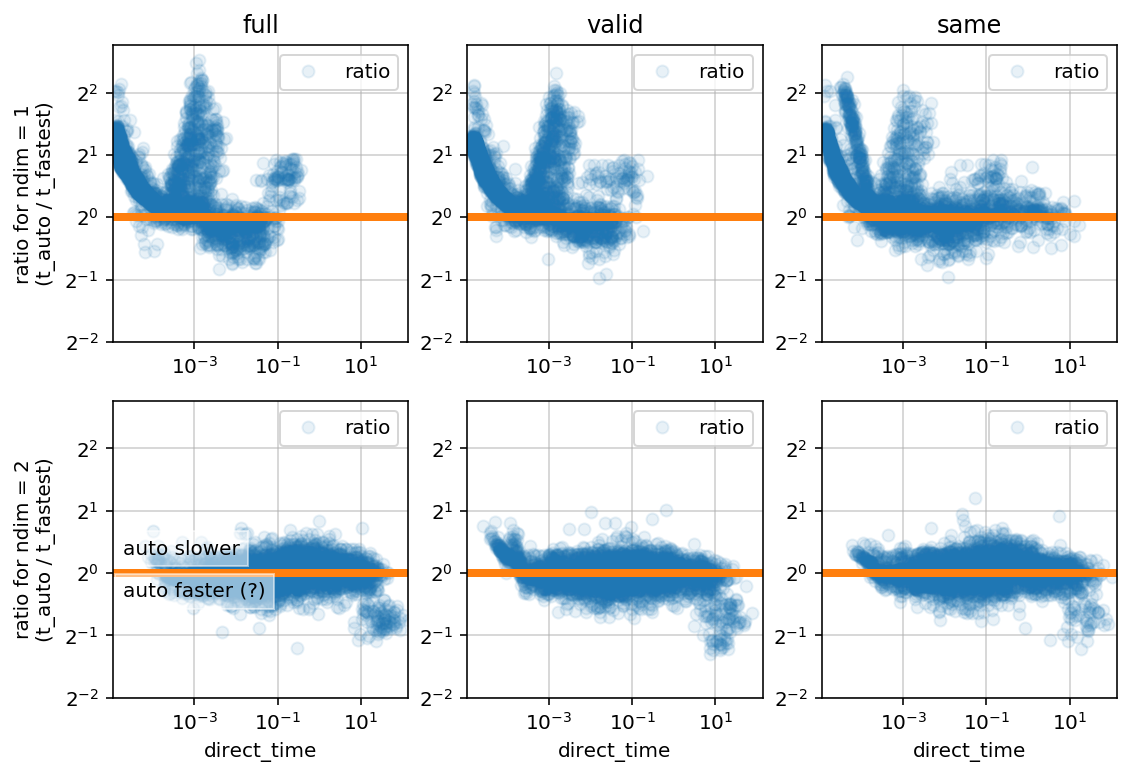

In [14]:
modes = ["full", "valid", "same"]
w = 3
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3 * w, 2 * w))
for k, mode in enumerate(modes):
    for ndim in [1, 2]:
        idx = (df["mode"] == mode) & (df["ndim"] == ndim)
        show = df[idx]
        ax = show.plot(x="direct_time", y="ratio", style=f"o", ax=axs[ndim - 1][k], alpha=0.1)
        _ = ax.set_yscale("log", basey=2)
        _ = ax.set_xscale("log")
        # _ = ax.text(0.2e-4, 1.25, "method='auto' predict slower method")
        # _ = ax.text(0.2e-4, 1 - 0.25, "method='auto' predict faster method")
        lim = df.ratio.max() + 1
        _ = ax.set_ylim(0.25, lim)
        _ = ax.set_xlim(df.direct_time.min(), df.direct_time.max())
        _ = ax.plot(ax.get_xlim(), [1, 1], linewidth=4)
        _ = ax.grid(alpha=0.6)
        if ndim == 1:
            _ = ax.set_title(mode)
            _ = ax.set_xlabel("")
        if k == 0:
            _ = ax.set_ylabel("ratio for ndim = {}\n(t_auto / t_fastest)".format(ndim))
        if k == 0 and ndim == 2:
            t = ax.text(2e-5, 1.23, "auto slower")
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))
            t = ax.text(2e-5, 1 - 0.23, "auto faster (?)")
            t.set_bbox(dict(facecolor='white', alpha=0.5, edgecolor='white'))

/Users/scott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


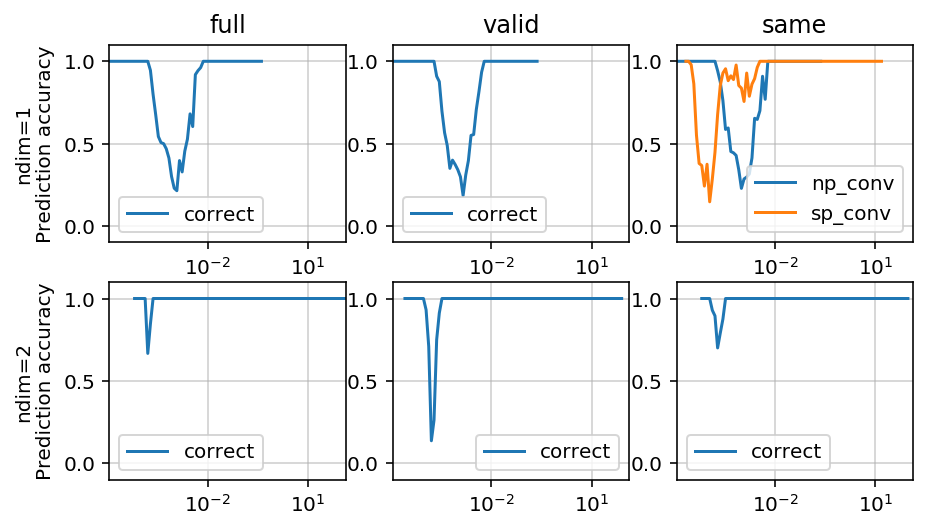

In [15]:
modes = ["full", "valid", "same"]
w = 2
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3 * 1.2 * w, 2 * w))
for k, mode in enumerate(modes):
    for ndim in [1, 2]:
        idx = (df["mode"] == mode) & (df["ndim"] == ndim)
        s = df[idx]
        for cond in sorted(s.np_conv.unique()):
            _i = (idx) & (s.np_conv == cond)
            show = s[_i].pivot_table(
                index="direct_time_binned",
                values="correct",
                aggfunc=np.mean,
            )
            kwargs = {"label": cond} if len(s.np_conv.unique()) > 1 else {"label": "correct"}
            ax = axs[ndim - 1][k]
            _ = ax.plot(show, "-",  **kwargs)
            _ = ax.set_xscale("log")
            _ = ax.set_ylim(-0.1, 1.1)
            _ = ax.set_xlim(df.direct_time.min(), df.direct_time.max())
            _ = ax.grid(alpha=0.6)
            _ = ax.legend(loc="best")
            if ndim == 1:
                _ = ax.set_title(mode)
                _ = ax.set_xlabel("")
            if k == 0:
                _ = ax.set_ylabel("ndim={}\nPrediction accuracy".format(ndim))
plt.savefig(f"accuracy-{fig_id}.png")

In [16]:
df.head()

,x_shape,h_shape,seed,mode,ndim,choose_conv_method,fft_time,direct_time,auto_time,x_shape0,...,h_shape1,ratio,correct,direct_time_binned,np_conv,x_size,h_size,in_size,in_size_binned,correct_float
0,13.0,8736.0,0,full,1,direct,0.000650,0.000259,0.000273,NaN,...,NaN,1.054278,True,0.000273,,13.0,8736.0,113568.0,1.278340e+05,1.0
1,NaN,NaN,0,full,2,fft,0.000456,0.085192,0.000391,18.0,...,87.0,0.857666,True,0.077887,,810.0,3654.0,2959740.0,3.276247e+06,1.0
2,13.0,8736.0,0,valid,1,direct,0.000376,0.000171,0.000189,NaN,...,NaN,1.104749,True,0.000158,,13.0,8736.0,113568.0,1.278340e+05,1.0
3,NaN,NaN,0,valid,2,fft,0.000387,0.016468,0.000318,45.0,...,42.0,0.820308,True,0.015095,,3915.0,756.0,2959740.0,3.276247e+06,1.0
4,13.0,8736.0,0,same,1,fft,0.000412,0.001042,0.000355,NaN,...,NaN,0.861530,True,0.000980,sp_conv,13.0,8736.0,113568.0,1.278340e+05,1.0


/Users/scott/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


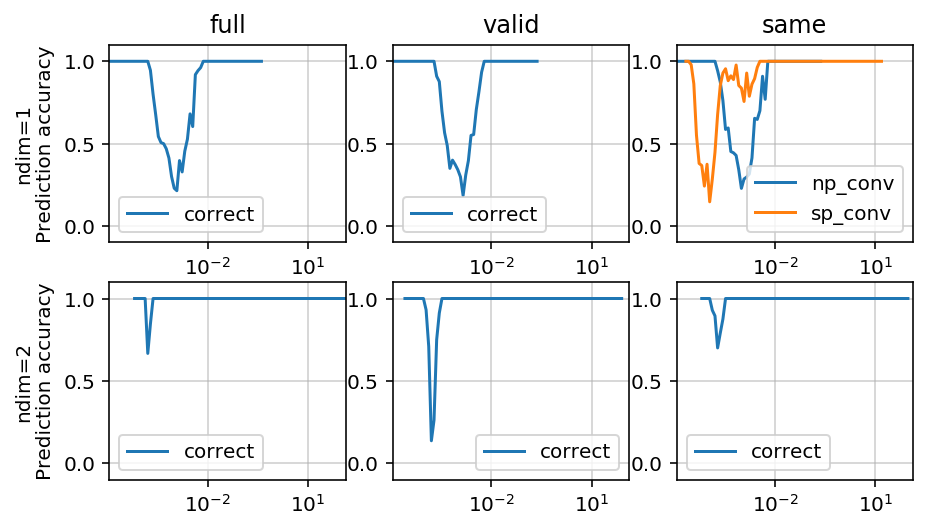

In [17]:
modes = ["full", "valid", "same"]
w = 2
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(3 * 1.2 * w, 2 * w))
for k, mode in enumerate(modes):
    for ndim in [1, 2]:
        idx = (df["mode"] == mode) & (df["ndim"] == ndim)
        s = df[idx]
        for cond in sorted(s.np_conv.unique()):
            _i = (idx) & (s.np_conv == cond)
            show = s[_i].pivot_table(
                index="direct_time_binned",
                values="correct",
                aggfunc=np.mean,
            )
            kwargs = {"label": cond} if len(s.np_conv.unique()) > 1 else {"label": "correct"}
            ax = axs[ndim - 1][k]
            _ = ax.plot(show, "-",  **kwargs)
            _ = ax.set_xscale("log")
            _ = ax.set_ylim(-0.1, 1.1)
            _ = ax.set_xlim(df.direct_time.min(), df.direct_time.max())
            _ = ax.grid(alpha=0.6)
            _ = ax.legend(loc="best")
            if ndim == 1:
                _ = ax.set_title(mode)
                _ = ax.set_xlabel("")
            if k == 0:
                _ = ax.set_ylabel("ndim={}\nPrediction accuracy".format(ndim))
plt.savefig(f"accuracy-{fig_id}.png")

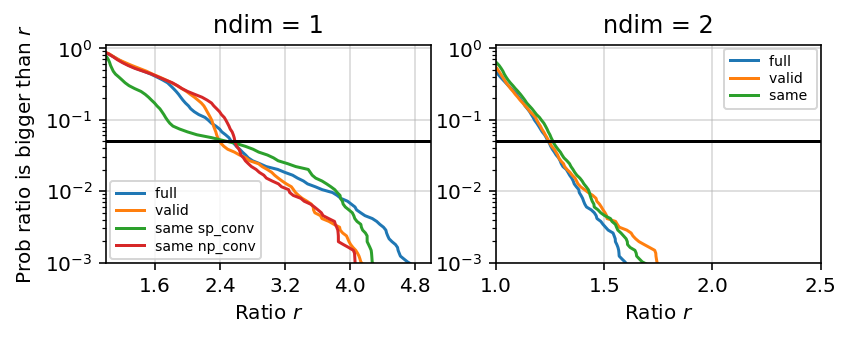

In [18]:
modes = ["full", "valid", "same"]
w = 2
fig, axs = plt.subplots(ncols=2, figsize=(2 * 1.6 * w, 1.0 * w))
for ndim in [1, 2]:
    for k, mode in enumerate(modes):
        idx = (df["mode"] == mode) & (df["ndim"] == ndim)
        show = df[idx]
        for cond in show.np_conv.unique():
            s = show[show.np_conv == cond]
            percentiles = {s.ratio.quantile(1 - q): q for q in np.logspace(-4, 0, num=100)}
            s = pd.Series(percentiles)
            ax = axs[ndim - 1]
            kwargs = {"label": mode + " " + cond}
            _ = ax.plot(s, **kwargs)
            _ = ax.set_title(f"ndim = {ndim}");
            _ = ax.set_xlabel("Ratio $r$")
            if ndim == 1:
                _ = ax.set_ylabel("Prob ratio is bigger than $r$")
            _ = ax.set_xlim(1, 5 if ndim == 1 else 2.5)
            _ = ax.set_xlim(1, None)
            if True:
                _ = ax.set_yscale("log")
                _ = ax.set_ylim(1e-3, 1.1)

            _ = ax.grid(alpha=0.5)
            loc = "upper right" if "1.2" not in fig_id else "lower right"
            loc = "lower left" if ndim == 1 else "upper right"
            _ = ax.legend(loc=loc, fontsize=7, ncol=1, labelspacing=0.25, borderaxespad=0.25)
            _ = ax.plot(ax.get_xlim(), [0.05, 0.05], "black")
            if ndim == 1:
                _ = ax.xaxis.set_major_locator(plt.MaxNLocator(5))
#             _ = ax.set_ylim(0, 0.1)
plt.savefig(f"ratio-{fig_id}.png", bbox_inches="tight")

In [19]:
df[df["ndim"] == 1].groupby("mode")["x_shape"].min()

mode
full     3.0
same     3.0
valid    3.0
Name: x_shape, dtype: float64

In [20]:
df[df["ndim"] == 1].groupby("mode")["h_shape"].min()

mode
full     3.0
same     3.0
valid    3.0
Name: h_shape, dtype: float64